In [40]:
!pip install -q tqdm
from tqdm import tqdm
import matplotlib.pyplot as plt
from MIC import *
from math import sqrt, pi
import numpy as np
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D

# Estimate Local Dependence Function with Kernels

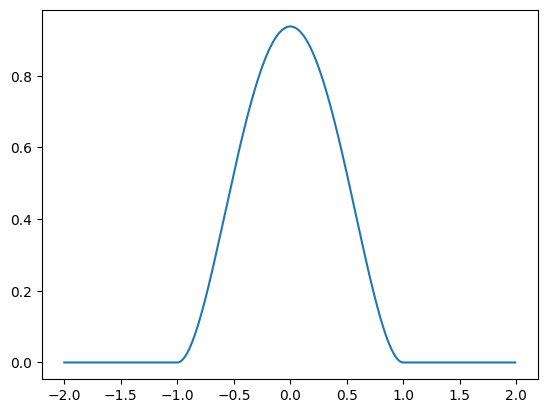

In [43]:
def biweight_univariate_density(u):
    if type(u) == float:
        u = np.array([u])
    res = np.where(u**2 <= 1, (15/16)*((1-u**2)**2), 0)
    return res 

plt.plot([u/100 for u in range(-200,200)],[biweight_univariate_density(u/100) for u in range(-200,200)])

In [44]:
kernel = biweight_univariate_density

def ldf_estimator(samples,x,y):
    n = len(samples)
    sigma1 = np.std(samples.T[0])#variance
    sigma2 = np.std(samples.T[1])#variance
    rho = np.corrcoef(samples.T)[0][1]#correlation 
    term1 = 5/7#gaussian kernelなら1/2sqrt(pi)
    term2 = 1/7#gaussian kernel なら1
    common = (2*sqrt(pi)*term1/term2)**(1/3)
    common *= (1-rho**2)**(5/12)
    common /= (1+(rho**2)/2)**(1/6)
    common /= n**(1/6)
    h1 = sigma1 * common #Frankの例で0.15464155821887748 0.15386506299591804くらい
    h2 = sigma2 * common
    #print("Bandwidths:",h1,h2)

    def g(i,j,samples_,x0,y0):
        res = []
        for k in range(n):
            Xk = samples_[k][0]
            Yk = samples_[k][1]     
            tmp = (Xk**i)*(Yk**j)*kernel((Xk-x0)/h1)*kernel((Yk-y0)/h2)
            tmp /= h1
            tmp /= h2
            res.append(tmp)
        return sum(res)/len(res)

    est = g(1,1,samples,x,y)-g(0,1,samples,x,y)*g(1,0,samples,x,y)/g(0,0,samples,x,y)
    est /= h1**2
    est /= h2**2
    est /= term2**2
    est /= g(0,0,samples,x,y)
    return est,g(0,0,samples,x,y),(sigma1,sigma2)


def ri_estimator(samples,x,y):
    n = len(samples)
    sigma1 = np.std(samples.T[0])#variance
    sigma2 = np.std(samples.T[1])#variance
    rho = np.corrcoef(samples.T)[0][1]#correlation 
    term1 = 5/7#gaussian kernelなら1/2sqrt(pi)
    term2 = 1/7#gaussian kernel なら1
    common = (2*sqrt(pi)*term1/term2)**(1/3)
    common *= (1-rho**2)**(5/12)
    common /= (1+(rho**2)/2)**(1/6)
    common /= n**(1/6)
    h1 = sigma1 * common
    h2 = sigma2 * common

    def g(i,j,samples_,x0,y0):
        res = []
        for k in range(n):
            Xk = samples_[k][0]
            Yk = samples_[k][1]     
            tmp = (Xk**i)*(Yk**j)*kernel((Xk-x0)/h1)*kernel((Yk-y0)/h2)
            tmp /= h1
            tmp /= h2
            res.append(tmp)
        return sum(res)/len(res)

    est = g(1,1,samples,x,y)-g(0,1,samples,x,y)*g(1,0,samples,x,y)/g(0,0,samples,x,y)
    est /= h1**2
    est /= h2**2
    est /= term2**2
    est /= g(0,0,samples,x,y)**2 #g00で1回余分に割っている
    return est,g(0,0,samples,x,y),(sigma1,sigma2)

### Frankコピュラの場合

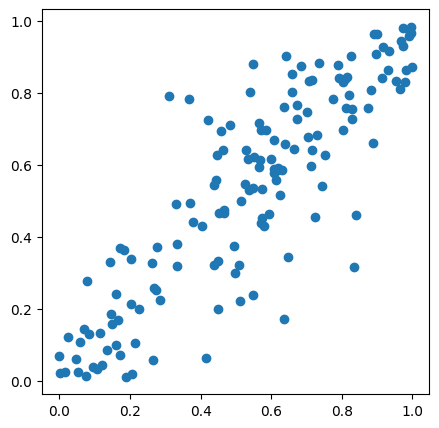

In [190]:
data = sampler.Invsamples_frank(theta=10,size=150)
plt.figure(figsize=(5,5))
plt.scatter(data[:,0],data[:,1])

In [191]:
# data = norm.ppf(data)
# plt.figure(figsize=(5,5))
# plt.scatter(data[:,0],data[:,1])

/var/folders/3h/q2tsvfyj5rnfwz5ldph0w6wm0000gn/T/ipykernel_37184/3730917006.py:29: RuntimeWarning: invalid value encountered in divide
  est = g(1,1,samples,x,y)-g(0,1,samples,x,y)*g(1,0,samples,x,y)/g(0,0,samples,x,y)


[0.88499463]


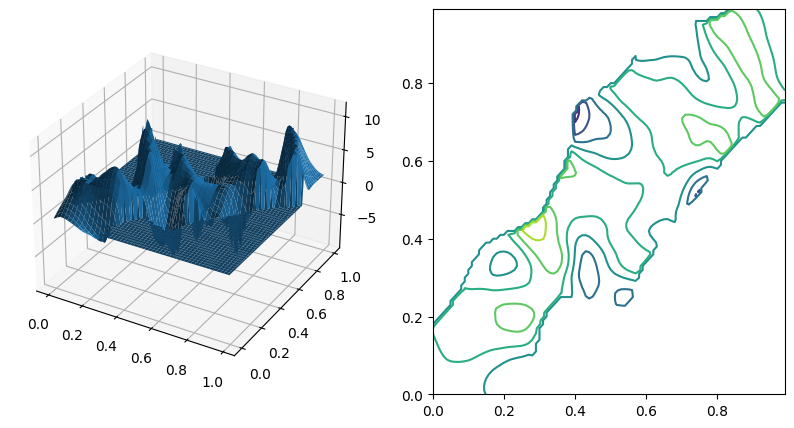

In [194]:
left_bottom = (0,0)
right_top = (1,1)
grid = 100
X, Y = np.mgrid[left_bottom[0]*grid:right_top[0]*grid, left_bottom[1]*grid:right_top[1]*grid]/grid
Z,f1,sd = ldf_estimator(data,X,Y)
cutoff = np.quantile(a = f1, q = [0.6])
masked = np.where(f1 < cutoff,0,Z)
print(cutoff)
#print(f1)
#print(masked)
masked = masked * sd[0] * sd[1]
#print(sd)
fig = plt.figure(figsize=(10, 5), facecolor="w")
ax = fig.add_subplot(121, projection="3d")
ax2 = fig.add_subplot(122)

#surf = ax.plot_surface(X, Y, Z)
surf = ax.plot_surface(X, Y, masked)
contour = ax2.contour(X, Y, masked)
#surf = ax.plot_surface(X, Y, f1)
#contour = ax2.contour(X, Y, f1)

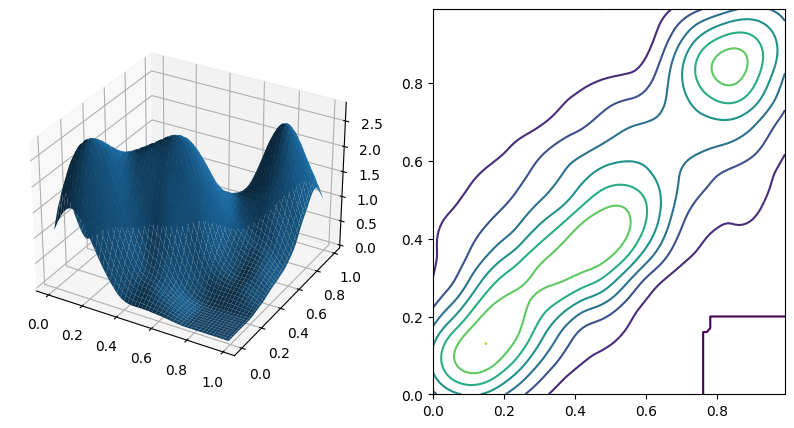

In [143]:
fig = plt.figure(figsize=(10, 5), facecolor="w")
ax = fig.add_subplot(121, projection="3d")
ax2 = fig.add_subplot(122)
surf = ax.plot_surface(X, Y, f1)
contour = ax2.contour(X, Y, f1)

/var/folders/3h/q2tsvfyj5rnfwz5ldph0w6wm0000gn/T/ipykernel_37184/2194435028.py:62: RuntimeWarning: invalid value encountered in divide
  est = g(1,1,samples,x,y)-g(0,1,samples,x,y)*g(1,0,samples,x,y)/g(0,0,samples,x,y)


[0.79500651]


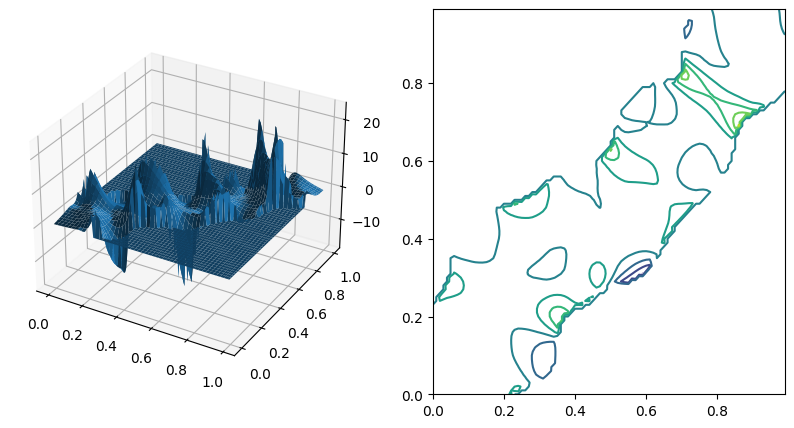

In [79]:
left_bottom = (0,0)
right_top = (1,1)
X, Y = np.mgrid[left_bottom[0]*100:right_top[0]*100, left_bottom[1]*100:right_top[1]*100]/100
Z,f1,sd = ri_estimator(data,X,Y)
cutoff = np.quantile(a = f1, q = [0.6])
masked = np.where(f1 < cutoff,0,Z)
print(cutoff)
#print(f1)
#print(masked)
masked = masked * sd[0] * sd[1]
#print(sd)
fig = plt.figure(figsize=(10, 5), facecolor="w")
ax = fig.add_subplot(121, projection="3d")
ax2 = fig.add_subplot(122)

#surf = ax.plot_surface(X, Y, Z)
surf = ax.plot_surface(X, Y, masked)
contour = ax2.contour(X, Y, masked)

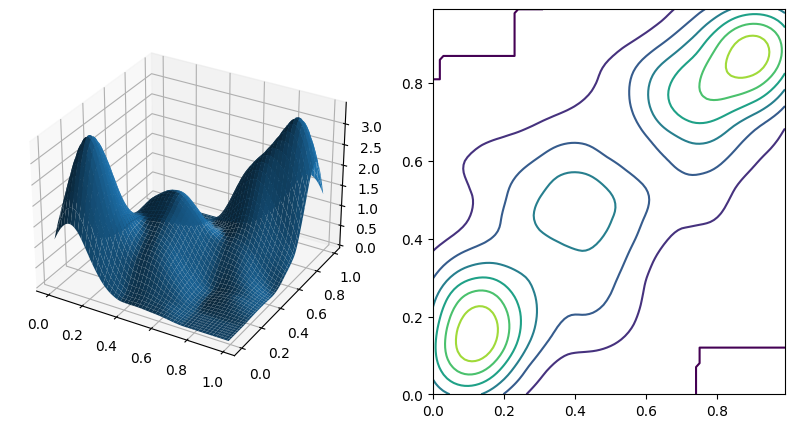

In [73]:
fig = plt.figure(figsize=(10, 5), facecolor="w")
ax = fig.add_subplot(121, projection="3d")
ax2 = fig.add_subplot(122)
surf = ax.plot_surface(X, Y, f1)
contour = ax2.contour(X, Y, f1)

In [74]:
def frank(theta,u,v):
    psi_inv_u = -np.log(-np.exp(-theta*u)+1)+np.log(-np.exp(-theta)+1)
    psi_inv_v = -np.log(-np.exp(-theta*v)+1)+np.log(-np.exp(-theta)+1)
    t = psi_inv_u + psi_inv_v
    y = -np.log(1-(1-np.exp(-theta))*np.exp(-t))/theta
    return y

def frank_density(theta,u,v):
    res = theta*(1-np.exp(-theta))*np.exp(-theta*(u+v))
    res /= (1-np.exp(-theta)-(1-np.exp(-theta*u))*(1-np.exp(-theta*v)))**2
    return res

def frank_ldf(theta,u,v):
    return frank_density(theta,u,v)*2*theta

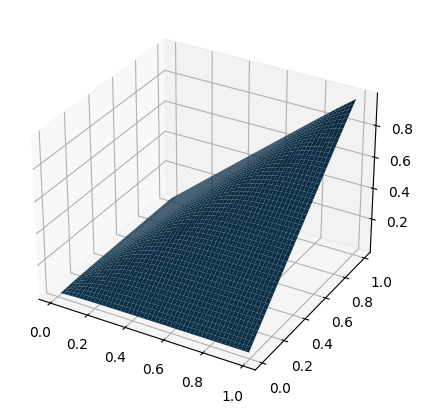

In [136]:
X, Y = np.mgrid[1:100, 1:100]/100
Z = frank(10,X,Y)
fig = plt.figure(figsize=(5, 5), facecolor="w")
ax = fig.add_subplot(111, projection="3d")

surf = ax.plot_surface(X, Y, Z)

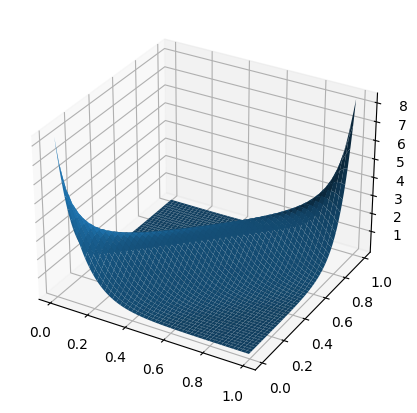

In [137]:
X, Y = np.mgrid[1:100, 1:100]/100
Z = frank_density(10,X,Y)
fig = plt.figure(figsize=(5, 5), facecolor="w")
ax = fig.add_subplot(111, projection="3d")

surf = ax.plot_surface(X, Y, Z)

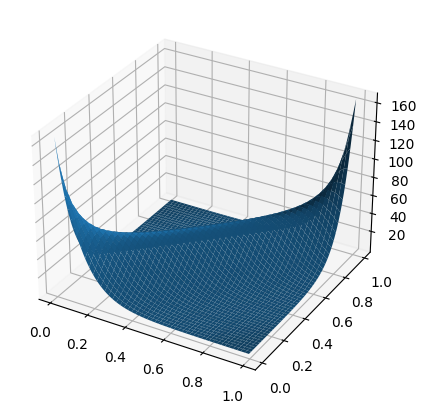

In [138]:
X, Y = np.mgrid[1:100, 1:100]/100
Z = frank_ldf(10,X,Y)
fig = plt.figure(figsize=(5, 5), facecolor="w")
ax = fig.add_subplot(111, projection="3d")

surf = ax.plot_surface(X, Y, Z)

### Clayton copulaの場合

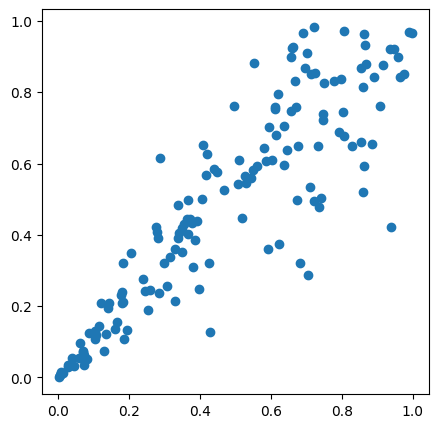

In [33]:
data = sampler.MOsamples_clayton(alpha=5, size=150)
plt.figure(figsize=(5,5))
plt.scatter(data[:,0],data[:,1])

/var/folders/3h/q2tsvfyj5rnfwz5ldph0w6wm0000gn/T/ipykernel_55163/1075174082.py:28: RuntimeWarning: invalid value encountered in divide
  est = g(1,1,samples,x,y)-g(0,1,samples,x,y)*g(1,0,samples,x,y)/g(0,0,samples,x,y)


[0.85579953]


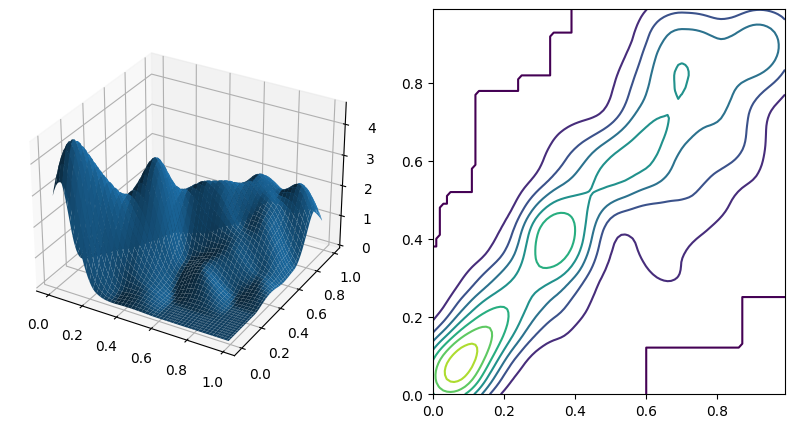

In [34]:
left_bottom = (0,0)
right_top = (1,1)
X, Y = np.mgrid[left_bottom[0]*100:right_top[0]*100, left_bottom[1]*100:right_top[1]*100]/100
Z,f1,sd = ldf_estimator(data,X,Y)
cutoff = np.quantile(a = f1, q = [0.6])
masked = np.where(f1 < cutoff,0,Z)
print(cutoff)
#print(f1)
#print(masked)
masked = masked * sd[0] * sd[1]
#print(sd)
fig = plt.figure(figsize=(10, 5), facecolor="w")
ax = fig.add_subplot(121, projection="3d")
ax2 = fig.add_subplot(122)

#surf = ax.plot_surface(X, Y, Z)
#surf = ax.plot_surface(X, Y, masked)
#contour = ax2.contour(X, Y, masked)
surf = ax.plot_surface(X, Y, f1)
contour = ax2.contour(X, Y, f1)

### bivariate Gaussianの場合

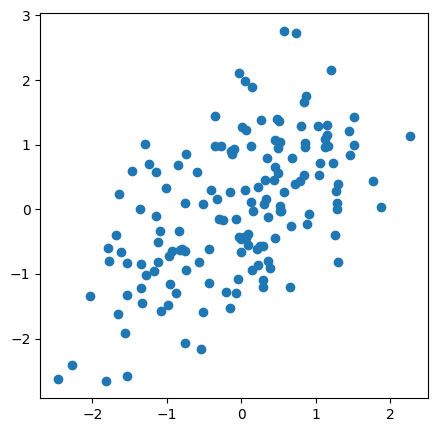

In [35]:
mean = [0, 0]
cov = [[1, 0.5], [0.5, 1]]  # diagonal covariance
data = np.random.multivariate_normal(mean, cov, 150)
plt.figure(figsize=(5,5))
plt.scatter(data[:,0],data[:,1])

/var/folders/3h/q2tsvfyj5rnfwz5ldph0w6wm0000gn/T/ipykernel_23139/253102567.py:28: RuntimeWarning: invalid value encountered in divide
  est = g(1,1,samples,x,y)-g(0,1,samples,x,y)*g(1,0,samples,x,y)/g(0,0,samples,x,y)


[0.01723338]


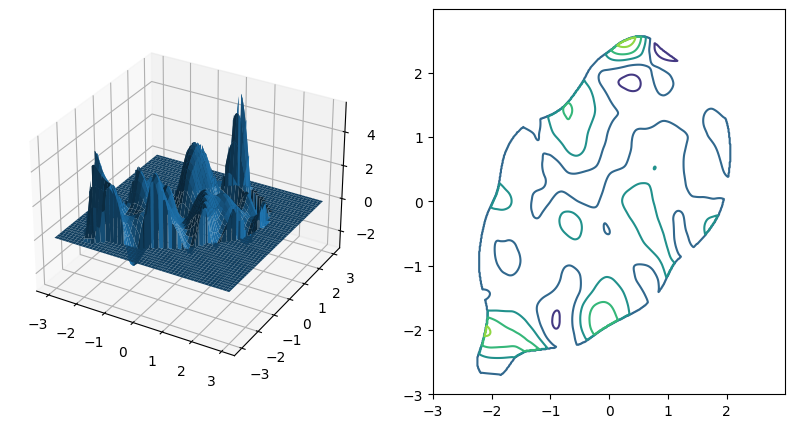

In [37]:
left_bottom = (-3,-3)
right_top = (3,3)
X, Y = np.mgrid[left_bottom[0]*100:right_top[0]*100, left_bottom[1]*100:right_top[1]*100]/100
Z,f1,sd = ldf_estimator(data,X,Y)
cutoff = np.quantile(a = f1, q = [0.6])
masked = np.where(f1 < cutoff,0,Z)
print(cutoff)
#print(f1)
#print(masked)
masked = masked * sd[0] * sd[1]
#print(sd)
fig = plt.figure(figsize=(10, 5), facecolor="w")
ax = fig.add_subplot(121, projection="3d")
ax2 = fig.add_subplot(122)

#surf = ax.plot_surface(X, Y, Z)
surf = ax.plot_surface(X, Y, masked)
contour = ax2.contour(X, Y, masked)

### Jones and Kochの例

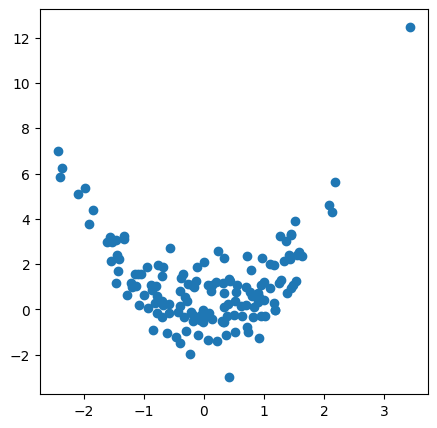

In [42]:
data_X = np.random.normal(0,1,150)
eps = np.random.normal(0,1,150)
data_Y = data_X**2+eps
data = np.concatenate([[data_X,data_Y]],axis=0).T
plt.figure(figsize=(5,5))
plt.scatter(data[:,0],data[:,1])

/var/folders/3h/q2tsvfyj5rnfwz5ldph0w6wm0000gn/T/ipykernel_23139/253102567.py:28: RuntimeWarning: invalid value encountered in divide
  est = g(1,1,samples,x,y)-g(0,1,samples,x,y)*g(1,0,samples,x,y)/g(0,0,samples,x,y)


[0.02808241]


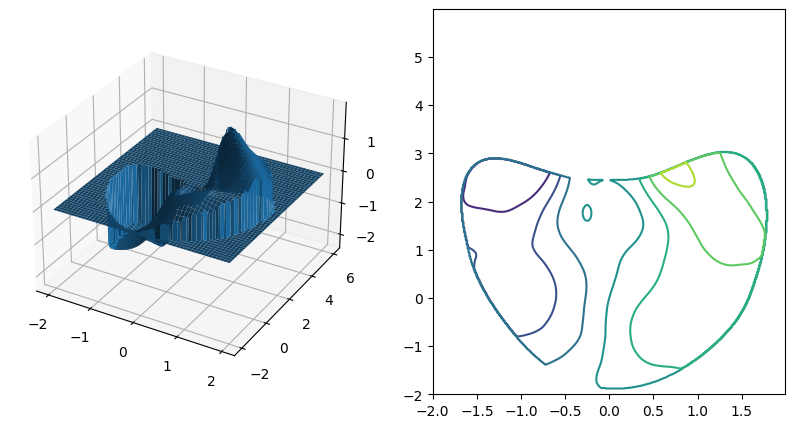

In [43]:
left_bottom = (-2,-2)
right_top = (2,6)
X, Y = np.mgrid[left_bottom[0]*100:right_top[0]*100, left_bottom[1]*100:right_top[1]*100]/100
Z,f1,sd = ldf_estimator(data,X,Y)
cutoff = np.quantile(a = f1, q = [0.6])
masked = np.where(f1 < cutoff,0,Z)
print(cutoff)
#print(f1)
#print(masked)
masked = masked * sd[0] * sd[1]
#print(sd)
fig = plt.figure(figsize=(10, 5), facecolor="w")
ax = fig.add_subplot(121, projection="3d")
ax2 = fig.add_subplot(122)

#surf = ax.plot_surface(X, Y, Z)
surf = ax.plot_surface(X, Y, masked)
contour = ax2.contour(X, Y, masked)

1000回の平均 Dependence map

In [236]:
record_dependence_maps = []
left_bottom = (-2,-2)
right_top = (2,6)
trial = 1000
for _ in range(trial):
    data_X = np.random.normal(0,1,150)
    eps = np.random.normal(0,1,150)
    data_Y = data_X**2+eps
    data = np.concatenate([[data_X,data_Y]],axis=0).T
    X, Y = np.mgrid[left_bottom[0]*100:right_top[0]*100, left_bottom[1]*100:right_top[1]*100]/100
    Z,f1,sd = ldf_estimator(data,X,Y)
    cutoff = np.quantile(a = f1, q = [0.6])
    masked = np.where(f1 < cutoff,0,Z)
    masked = masked * sd[0] * sd[1]
    record_dependence_maps.append(masked)    

/var/folders/3h/q2tsvfyj5rnfwz5ldph0w6wm0000gn/T/ipykernel_22720/253102567.py:28: RuntimeWarning: invalid value encountered in divide
  est = g(1,1,samples,x,y)-g(0,1,samples,x,y)*g(1,0,samples,x,y)/g(0,0,samples,x,y)


NameError: name 'record_dependence_maps' is not defined

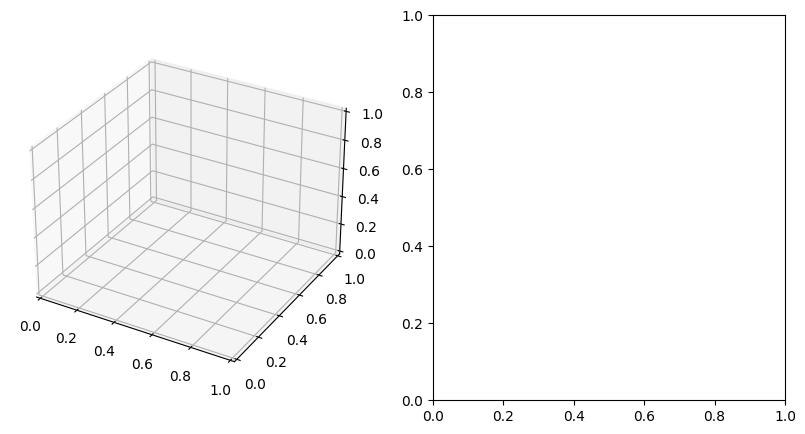

In [38]:
fig = plt.figure(figsize=(10, 5), facecolor="w")
ax = fig.add_subplot(121, projection="3d")
ax2 = fig.add_subplot(122)
surf = ax.plot_surface(X, Y, np.sum(record_dependence_maps,axis=1)/trial)
contour = ax2.contour(X, Y, np.sum(record_dependence_maps,axis=1)/trial)

$$\frac{1}{p(x,y)}\frac{\partial^2}{\partial x \partial y} \log{p(x,y)}$$
を直接推定できないか.

## FrankのLDFを1000回推定した平均

In [182]:
res = np.zeros((100,100))
left_bottom,right_top = (0,0),(1,1)
X, Y = np.mgrid[left_bottom[0]*100:right_top[0]*100, left_bottom[1]*100:right_top[1]*100]/100
for i in tqdm(range(1000)):
    data = sampler.Invsamples_frank(theta=10,size=150)
    left_bottom = (0,0)
    Z,f1,sd = ldf_estimator(data,X,Y)
    cutoff = np.quantile(a = f1, q = [0.6])
    masked = np.where(f1 < cutoff,0,Z)
    masked = masked * sd[0] * sd[1]
    res = res + masked
res /= 1000

  0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/3h/q2tsvfyj5rnfwz5ldph0w6wm0000gn/T/ipykernel_37184/3730917006.py:29: RuntimeWarning: invalid value encountered in divide
  est = g(1,1,samples,x,y)-g(0,1,samples,x,y)*g(1,0,samples,x,y)/g(0,0,samples,x,y)
100%|██████████| 1000/1000 [01:15<00:00, 13.30it/s]


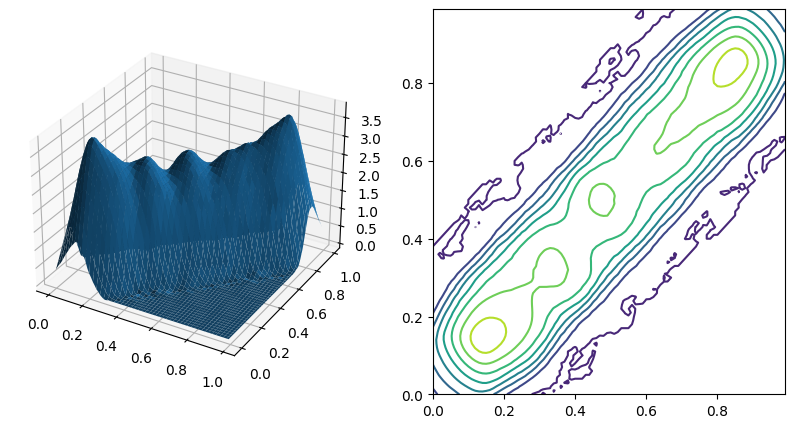

In [184]:
fig = plt.figure(figsize=(10, 5), facecolor="w")
ax = fig.add_subplot(121, projection="3d")
ax2 = fig.add_subplot(122)
surf = ax.plot_surface(X, Y, res)
contour = ax2.contour(X, Y, res)

## FrankのRIを1000回推定した平均

In [174]:
res = np.zeros((100,100))
left_bottom,right_top = (0,0),(1,1)
X, Y = np.mgrid[left_bottom[0]*100:right_top[0]*100, left_bottom[1]*100:right_top[1]*100]/100
for i in tqdm(range(1000)):
    data = sampler.Invsamples_frank(theta=10,size=150)
    left_bottom = (0,0)
    Z,f1,sd = ri_estimator(data,X,Y)
    cutoff = np.quantile(a = f1, q = [0.6])
    masked = np.where(f1 < cutoff,0,Z)
    masked = masked * sd[0] * sd[1]
    res = res + masked
res /= 1000

  0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/3h/q2tsvfyj5rnfwz5ldph0w6wm0000gn/T/ipykernel_37184/91821329.py:62: RuntimeWarning: invalid value encountered in divide
  est = g(1,1,samples,x,y)-g(0,1,samples,x,y)*g(1,0,samples,x,y)/g(0,0,samples,x,y)
100%|██████████| 1000/1000 [01:12<00:00, 13.82it/s]


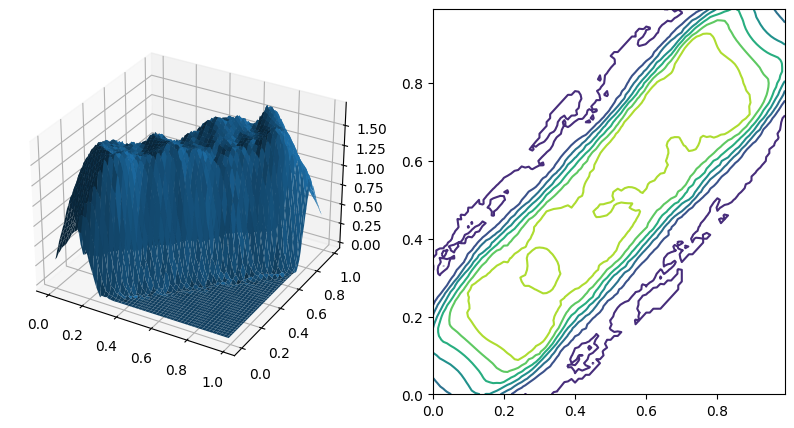

In [175]:
fig = plt.figure(figsize=(10, 5), facecolor="w")
ax = fig.add_subplot(121, projection="3d")
ax2 = fig.add_subplot(122)
surf = ax.plot_surface(X, Y, res)
contour = ax2.contour(X, Y, res)

## FrankをGaussian marginalsで変換してからRIを1000回推定した平均

In [49]:
grid = 100
left_bottom,right_top = (-1,-1),(1,1)
X, Y = np.mgrid[left_bottom[0]*grid:right_top[0]*grid, left_bottom[1]*grid:right_top[1]*grid]/grid
res = np.zeros(X.shape)
for i in tqdm(range(1000)):
    data = sampler.Invsamples_frank(theta=3,size=150)
    data = norm.ppf(data, loc=0, scale=1)
    left_bottom = (0,0)
    Z,f1,sd = ri_estimator(data,X,Y)
    cutoff = np.quantile(a = f1, q = [0.6])
    masked = np.where(f1 < cutoff,0,Z)
    masked = masked * sd[0] * sd[1]
    res = res + masked
res /= 1000

100%|██████████| 1000/1000 [04:50<00:00,  3.45it/s]


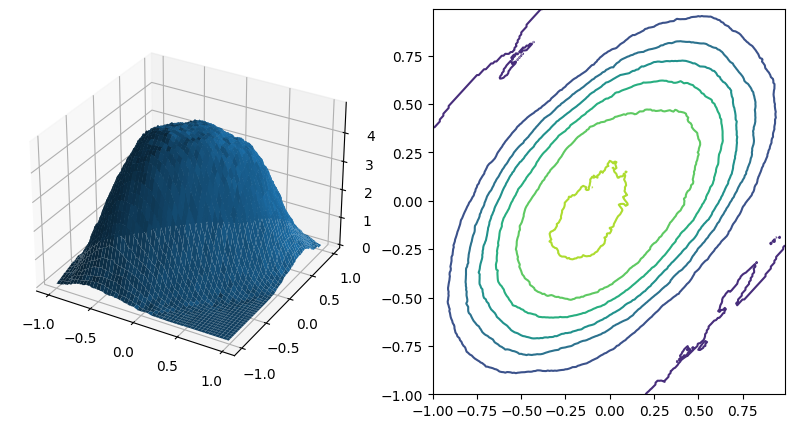

In [50]:
fig = plt.figure(figsize=(10, 5), facecolor="w")
ax = fig.add_subplot(121, projection="3d")
ax2 = fig.add_subplot(122)
surf = ax.plot_surface(X, Y, res)
contour = ax2.contour(X, Y, res)

## Bivariate GaussianのRIを1000回推定した平均（失敗）

In [57]:
grid = 100
left_bottom,right_top = (-1,-1),(1,1)
X, Y = np.mgrid[left_bottom[0]*grid:right_top[0]*grid, left_bottom[1]*grid:right_top[1]*grid]/grid
res = np.zeros(X.shape)
for i in tqdm(range(1000)):
    data = np.random.multivariate_normal(mean = [0, 0], cov = [[1, 0.5], [0.5, 1]], size = 150)
    left_bottom = (0,0)
    Z,f1,sd = ri_estimator(data,X,Y)
    cutoff = np.quantile(a = f1, q = [0.6])
    masked = np.where(f1 < cutoff,0,Z)
    masked = masked * sd[0] * sd[1]
    res = res + masked
res /= 1000

100%|██████████| 1000/1000 [04:37<00:00,  3.61it/s]


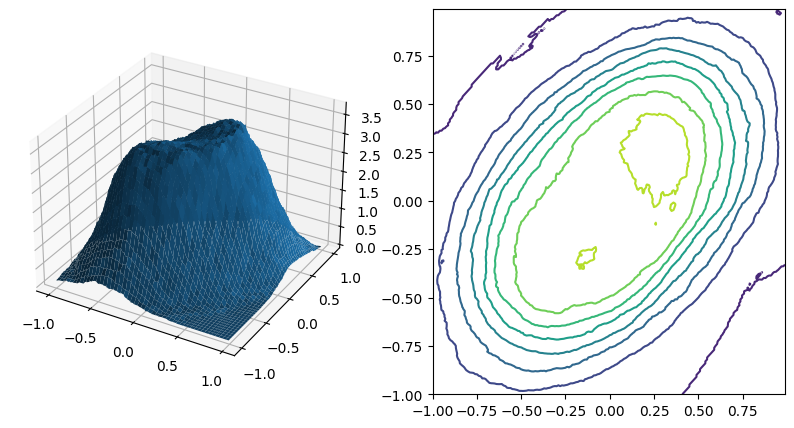

In [59]:
fig = plt.figure(figsize=(10, 5), facecolor="w")
ax = fig.add_subplot(121, projection="3d")
ax2 = fig.add_subplot(122)
surf = ax.plot_surface(X, Y, res)
contour = ax2.contour(X, Y, res)

In [60]:
res.max()

3.7364113372469263

## ClaytonのLDFを1000回推定した平均

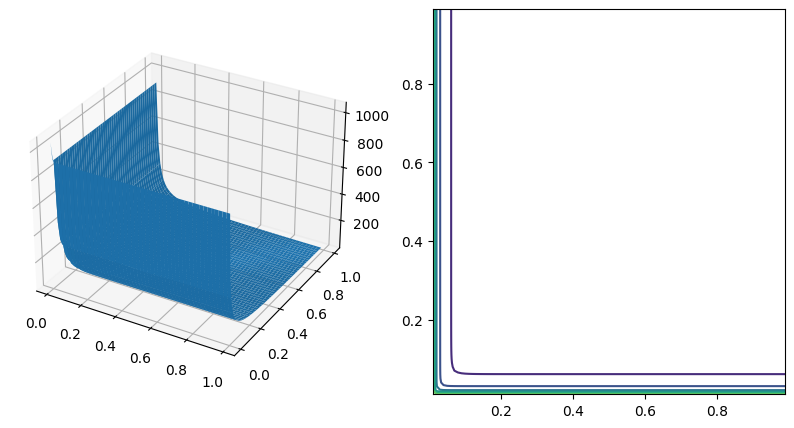

In [244]:
#Ground truth
def clayton_pdf(u,v,alpha):
    return (1+alpha)*(u**(-1-alpha))*(v**(-1-alpha))*((u**-alpha + v**-alpha -1)**(-2-1/alpha))

def clayton_cdf(u,v,alpha):
    return 1/(u**-alpha + v**-alpha -1)**(1/alpha)


left_bottom,right_top = (0.01,0.01),(1,1)
X, Y = np.mgrid[left_bottom[0]*100:right_top[0]*100, left_bottom[1]*100:right_top[1]*100]/100
alpha = 5
#Z = clayton_pdf(X,Y,alpha)
#Z = ((1+2*alpha)*alpha/(1+alpha))*(clayton_pdf(X,Y,alpha)/clayton_cdf(X,Y,alpha))
Z = ((1+2*alpha)*alpha/(1+alpha))*(1/clayton_cdf(X,Y,alpha))
fig = plt.figure(figsize=(10, 5), facecolor="w")
ax = fig.add_subplot(121, projection="3d")
ax2 = fig.add_subplot(122)
surf = ax.plot_surface(X, Y, Z)
contour = ax2.contour(X, Y, Z)

In [211]:
res = np.zeros((100,100))
left_bottom,right_top = (0,0),(1,1)
X, Y = np.mgrid[left_bottom[0]*100:right_top[0]*100, left_bottom[1]*100:right_top[1]*100]/100
for i in tqdm(range(1000)):
    data = sampler.MOsamples_clayton(alpha=5,size=150)
    left_bottom = (0,0)
    Z,f1,sd = ldf_estimator(data,X,Y)
    cutoff = np.quantile(a = f1, q = [0.6])
    masked = np.where(f1 < cutoff,0,Z)
    masked = masked * sd[0] * sd[1]
    res = res + masked
res /= 1000

  0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/3h/q2tsvfyj5rnfwz5ldph0w6wm0000gn/T/ipykernel_37184/3730917006.py:29: RuntimeWarning: invalid value encountered in divide
  est = g(1,1,samples,x,y)-g(0,1,samples,x,y)*g(1,0,samples,x,y)/g(0,0,samples,x,y)
100%|██████████| 1000/1000 [03:27<00:00,  4.81it/s]


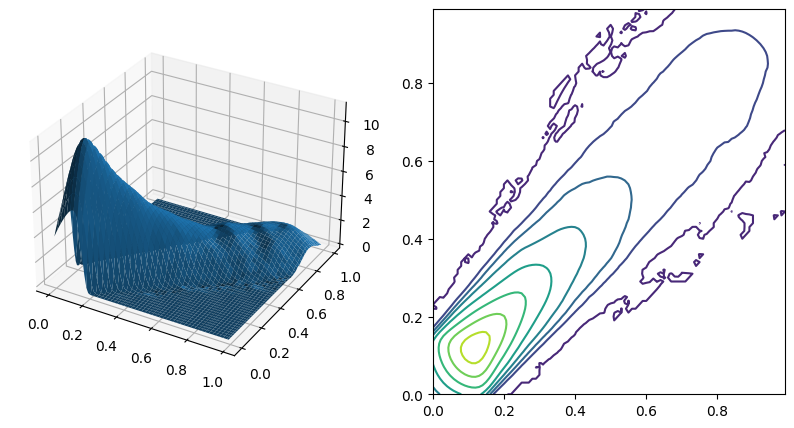

In [212]:
fig = plt.figure(figsize=(10, 5), facecolor="w")
ax = fig.add_subplot(121, projection="3d")
ax2 = fig.add_subplot(122)
surf = ax.plot_surface(X, Y, res)
contour = ax2.contour(X, Y, res)

## ClaytonのRIを1000回推定した平均

In [213]:
res = np.zeros((100,100))
left_bottom,right_top = (0,0),(1,1)
X, Y = np.mgrid[left_bottom[0]*100:right_top[0]*100, left_bottom[1]*100:right_top[1]*100]/100
for i in tqdm(range(1000)):
    data = sampler.MOsamples_clayton(alpha=5,size=150)
    left_bottom = (0,0)
    Z,f1,sd = ri_estimator(data,X,Y)
    cutoff = np.quantile(a = f1, q = [0.6])
    masked = np.where(f1 < cutoff,0,Z)
    masked = masked * sd[0] * sd[1]
    res = res + masked
res /= 1000

  0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/3h/q2tsvfyj5rnfwz5ldph0w6wm0000gn/T/ipykernel_37184/3730917006.py:62: RuntimeWarning: invalid value encountered in divide
  est = g(1,1,samples,x,y)-g(0,1,samples,x,y)*g(1,0,samples,x,y)/g(0,0,samples,x,y)
100%|██████████| 1000/1000 [02:36<00:00,  6.40it/s]


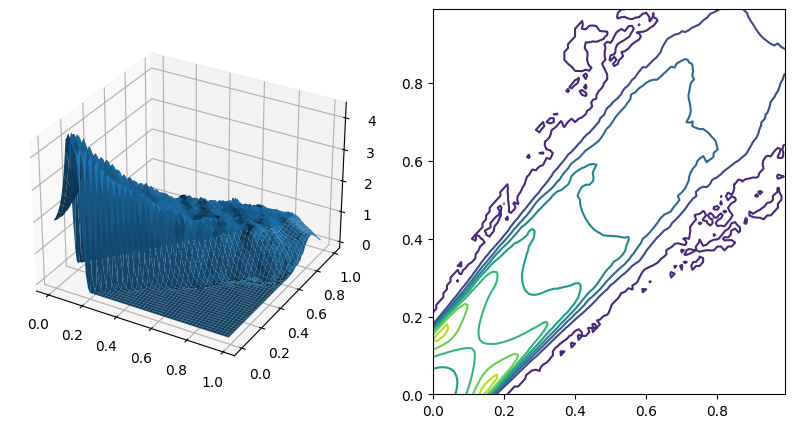

In [214]:
fig = plt.figure(figsize=(10, 5), facecolor="w")
ax = fig.add_subplot(121, projection="3d")
ax2 = fig.add_subplot(122)
surf = ax.plot_surface(X, Y, res)
contour = ax2.contour(X, Y, res)

## ClaytonをGaussian marginalsで変換して1000回推定した平均

In [215]:
grid = 100
left_bottom,right_top = (-1,-1),(1,1)
X, Y = np.mgrid[left_bottom[0]*grid:right_top[0]*grid, left_bottom[1]*grid:right_top[1]*grid]/grid
res = np.zeros(X.shape)
for i in tqdm(range(1000)):
    data = sampler.MOsamples_clayton(alpha=5,size=150)
    data = norm.ppf(data, loc=0, scale=1)
    left_bottom = (0,0)
    Z,f1,sd = ri_estimator(data,X,Y)
    cutoff = np.quantile(a = f1, q = [0.6])
    masked = np.where(f1 < cutoff,0,Z)
    masked = masked * sd[0] * sd[1]
    res = res + masked
res /= 1000

  0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/3h/q2tsvfyj5rnfwz5ldph0w6wm0000gn/T/ipykernel_37184/3730917006.py:62: RuntimeWarning: invalid value encountered in divide
  est = g(1,1,samples,x,y)-g(0,1,samples,x,y)*g(1,0,samples,x,y)/g(0,0,samples,x,y)
100%|██████████| 1000/1000 [07:37<00:00,  2.19it/s]


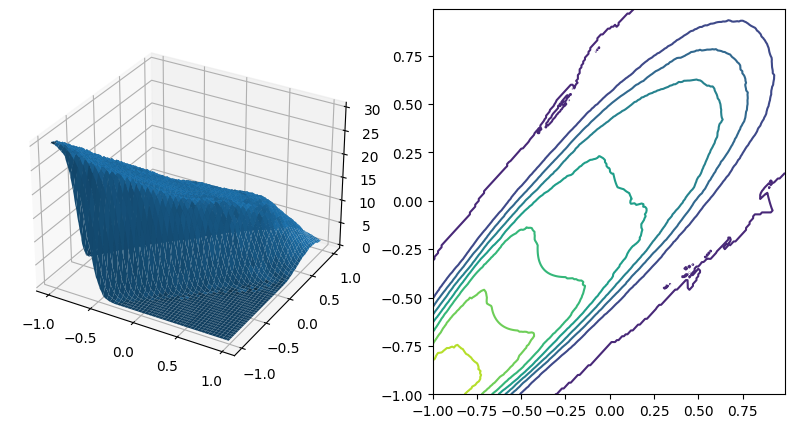

In [216]:
fig = plt.figure(figsize=(10, 5), facecolor="w")
ax = fig.add_subplot(121, projection="3d")
ax2 = fig.add_subplot(122)
surf = ax.plot_surface(X, Y, res)
contour = ax2.contour(X, Y, res)

## FGMのLDFを1000回推定した平均
- 棄却法
- Rにはある

In [ ]:
res = np.zeros((100,100))
left_bottom,right_top = (0,0),(1,1)
X, Y = np.mgrid[left_bottom[0]*100:right_top[0]*100, left_bottom[1]*100:right_top[1]*100]/100
for i in tqdm(range(1000)):
    data = 
    left_bottom = (0,0)
    Z,f1,sd = ldf_estimator(data,X,Y)
    cutoff = np.quantile(a = f1, q = [0.6])
    masked = np.where(f1 < cutoff,0,Z)
    masked = masked * sd[0] * sd[1]
    res = res + masked
res /= 1000

In [ ]:
fig = plt.figure(figsize=(10, 5), facecolor="w")
ax = fig.add_subplot(121, projection="3d")
ax2 = fig.add_subplot(122)
surf = ax.plot_surface(X, Y, res)
contour = ax2.contour(X, Y, res)

# 長方形領域に対してKendall's $\tau$を計算する

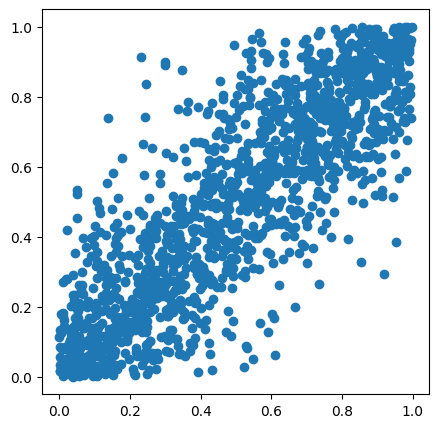

In [35]:
data = sampler.Invsamples_frank(theta=10,size=1500)
plt.figure(figsize=(5,5))
plt.scatter(data[:,0],data[:,1])

In [36]:
import pandas as pd
from scipy import stats

def rect_tau(p1,p2,q1,q2,data):
    df = pd.DataFrame(data,columns=["U","V"])
    df = df.query("@p1 <= U <= @p2 and @q1 <= V <= @q2")
    tau = stats.kendalltau(df.iloc[:,0].tolist(), df.iloc[:,1].tolist()).statistic
    N = len(data)
    C1 = len(df.query("0 <= U <= @p2 and 0 <= V <= @q2"))
    C2 = len(df.query("0 <= U <= @p2 and 0 <= V <= @q1"))
    C3 = len(df.query("0 <= U <= @p1 and 0 <= V <= @q2"))
    C4 = len(df.query("0 <= U <= @p1 and 0 <= V <= @q1"))
    #print((C1/N - C2/N - C3/N + C4/N)**2)
    #tau /= (C1/N - C2/N - C3/N + C4/N)**2
    return tau

In [38]:
rect_tau(2/10,3/10,0,1/10,data)

0.05928853754940712